# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [2]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [3]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [4]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [5]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [6]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [7]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [8]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :34.461%
 -- 1000 Games WIN : 326 DRAW : 54 LOSS : 620
Total win rate : 34.461%
 -- TOTAL Games WIN : 326 DRAW : 54 LOSS : 620
========== Training : Episode  2000  ===========
Recent 1000 games win rate :35.919%
 -- 1000 Games WIN : 338 DRAW : 59 LOSS : 603
Total win rate : 35.188%
 -- TOTAL Games WIN : 664 DRAW : 113 LOSS : 1223
========== Training : Episode  3000  ===========
Recent 1000 games win rate :36.931%
 -- 1000 Games WIN : 349 DRAW : 55 LOSS : 596
Total win rate : 35.770%
 -- TOTAL Games WIN : 1013 DRAW : 168 LOSS : 1819
========== Training : Episode  4000  ===========
Recent 1000 games win rate :36.642%
 -- 1000 Games WIN : 347 DRAW : 53 LOSS : 600
Total win rate : 35.988%
 -- TOTAL Games WIN : 1360 DRAW : 221 LOSS : 2419
========== Training : Episode  5000  ===========
Recent 1000 games win rate :35.393%
 -- 1000 Games WIN : 338 DRAW : 45 LOSS : 617
Total win rate : 35.868%
 -- TOTAL Games WIN : 16

========== Training : Episode  46000  ===========
Recent 1000 games win rate :35.213%
 -- 1000 Games WIN : 331 DRAW : 60 LOSS : 609
Total win rate : 35.455%
 -- TOTAL Games WIN : 15329 DRAW : 2765 LOSS : 27906
========== Training : Episode  47000  ===========
Recent 1000 games win rate :39.144%
 -- 1000 Games WIN : 366 DRAW : 65 LOSS : 569
Total win rate : 35.533%
 -- TOTAL Games WIN : 15695 DRAW : 2830 LOSS : 28475
========== Training : Episode  48000  ===========
Recent 1000 games win rate :31.780%
 -- 1000 Games WIN : 300 DRAW : 56 LOSS : 644
Total win rate : 35.455%
 -- TOTAL Games WIN : 15995 DRAW : 2886 LOSS : 29119
========== Training : Episode  49000  ===========
Recent 1000 games win rate :36.691%
 -- 1000 Games WIN : 346 DRAW : 57 LOSS : 597
Total win rate : 35.480%
 -- TOTAL Games WIN : 16341 DRAW : 2943 LOSS : 29716
========== Training : Episode  50000  ===========
Recent 1000 games win rate :37.473%
 -- 1000 Games WIN : 353 DRAW : 58 LOSS : 589
Total win rate : 35.520%
 --

========== Training : Episode  88000  ===========
Recent 1000 games win rate :32.660%
 -- 1000 Games WIN : 307 DRAW : 60 LOSS : 633
Total win rate : 35.335%
 -- TOTAL Games WIN : 29216 DRAW : 5317 LOSS : 53467
========== Training : Episode  89000  ===========
Recent 1000 games win rate :36.017%
 -- 1000 Games WIN : 340 DRAW : 56 LOSS : 604
Total win rate : 35.343%
 -- TOTAL Games WIN : 29556 DRAW : 5373 LOSS : 54071
========== Training : Episode  90000  ===========
Recent 1000 games win rate :34.457%
 -- 1000 Games WIN : 327 DRAW : 51 LOSS : 622
Total win rate : 35.333%
 -- TOTAL Games WIN : 29883 DRAW : 5424 LOSS : 54693
========== Training : Episode  91000  ===========
Recent 1000 games win rate :36.915%
 -- 1000 Games WIN : 347 DRAW : 60 LOSS : 593
Total win rate : 35.350%
 -- TOTAL Games WIN : 30230 DRAW : 5484 LOSS : 55286
========== Training : Episode  92000  ===========
Recent 1000 games win rate :37.010%
 -- 1000 Games WIN : 349 DRAW : 57 LOSS : 594
Total win rate : 35.368%
 --

========== Training : Episode  130000  ===========
Recent 1000 games win rate :35.219%
 -- 1000 Games WIN : 330 DRAW : 63 LOSS : 607
Total win rate : 35.349%
 -- TOTAL Games WIN : 43213 DRAW : 7753 LOSS : 79034
========== Training : Episode  131000  ===========
Recent 1000 games win rate :37.433%
 -- 1000 Games WIN : 350 DRAW : 65 LOSS : 585
Total win rate : 35.365%
 -- TOTAL Games WIN : 43563 DRAW : 7818 LOSS : 79619
========== Training : Episode  132000  ===========
Recent 1000 games win rate :37.647%
 -- 1000 Games WIN : 352 DRAW : 65 LOSS : 583
Total win rate : 35.382%
 -- TOTAL Games WIN : 43915 DRAW : 7883 LOSS : 80202
========== Training : Episode  133000  ===========
Recent 1000 games win rate :32.309%
 -- 1000 Games WIN : 305 DRAW : 56 LOSS : 639
Total win rate : 35.359%
 -- TOTAL Games WIN : 44220 DRAW : 7939 LOSS : 80841
========== Training : Episode  134000  ===========
Recent 1000 games win rate :33.723%
 -- 1000 Games WIN : 317 DRAW : 60 LOSS : 623
Total win rate : 35.347

========== Training : Episode  173000  ===========
Recent 1000 games win rate :34.009%
 -- 1000 Games WIN : 319 DRAW : 62 LOSS : 619
Total win rate : 35.445%
 -- TOTAL Games WIN : 57670 DRAW : 10299 LOSS : 105031
========== Training : Episode  174000  ===========
Recent 1000 games win rate :34.004%
 -- 1000 Games WIN : 321 DRAW : 56 LOSS : 623
Total win rate : 35.437%
 -- TOTAL Games WIN : 57991 DRAW : 10355 LOSS : 105654
========== Training : Episode  175000  ===========
Recent 1000 games win rate :37.339%
 -- 1000 Games WIN : 348 DRAW : 68 LOSS : 584
Total win rate : 35.448%
 -- TOTAL Games WIN : 58339 DRAW : 10423 LOSS : 106238
========== Training : Episode  176000  ===========
Recent 1000 games win rate :34.538%
 -- 1000 Games WIN : 325 DRAW : 59 LOSS : 616
Total win rate : 35.443%
 -- TOTAL Games WIN : 58664 DRAW : 10482 LOSS : 106854
========== Training : Episode  177000  ===========
Recent 1000 games win rate :34.871%
 -- 1000 Games WIN : 325 DRAW : 68 LOSS : 607
Total win rate 

========== Training : Episode  215000  ===========
Recent 1000 games win rate :33.084%
 -- 1000 Games WIN : 310 DRAW : 63 LOSS : 627
Total win rate : 35.407%
 -- TOTAL Games WIN : 71573 DRAW : 12854 LOSS : 130573
========== Training : Episode  216000  ===========
Recent 1000 games win rate :35.851%
 -- 1000 Games WIN : 337 DRAW : 60 LOSS : 603
Total win rate : 35.409%
 -- TOTAL Games WIN : 71910 DRAW : 12914 LOSS : 131176
========== Training : Episode  217000  ===========
Recent 1000 games win rate :34.904%
 -- 1000 Games WIN : 326 DRAW : 66 LOSS : 608
Total win rate : 35.406%
 -- TOTAL Games WIN : 72236 DRAW : 12980 LOSS : 131784
========== Training : Episode  218000  ===========
Recent 1000 games win rate :35.661%
 -- 1000 Games WIN : 337 DRAW : 55 LOSS : 608
Total win rate : 35.408%
 -- TOTAL Games WIN : 72573 DRAW : 13035 LOSS : 132392
========== Training : Episode  219000  ===========
Recent 1000 games win rate :33.511%
 -- 1000 Games WIN : 315 DRAW : 60 LOSS : 625
Total win rate 

========== Training : Episode  256000  ===========
Recent 1000 games win rate :32.444%
 -- 1000 Games WIN : 304 DRAW : 63 LOSS : 633
Total win rate : 35.380%
 -- TOTAL Games WIN : 85185 DRAW : 15225 LOSS : 155590
========== Training : Episode  257000  ===========
Recent 1000 games win rate :35.895%
 -- 1000 Games WIN : 341 DRAW : 50 LOSS : 609
Total win rate : 35.382%
 -- TOTAL Games WIN : 85526 DRAW : 15275 LOSS : 156199
========== Training : Episode  258000  ===========
Recent 1000 games win rate :37.234%
 -- 1000 Games WIN : 350 DRAW : 60 LOSS : 590
Total win rate : 35.389%
 -- TOTAL Games WIN : 85876 DRAW : 15335 LOSS : 156789
========== Training : Episode  259000  ===========
Recent 1000 games win rate :35.138%
 -- 1000 Games WIN : 331 DRAW : 58 LOSS : 611
Total win rate : 35.388%
 -- TOTAL Games WIN : 86207 DRAW : 15393 LOSS : 157400
========== Training : Episode  260000  ===========
Recent 1000 games win rate :36.431%
 -- 1000 Games WIN : 345 DRAW : 53 LOSS : 602
Total win rate 

========== Training : Episode  300000  ===========
Recent 1000 games win rate :35.238%
 -- 1000 Games WIN : 333 DRAW : 55 LOSS : 612
Total win rate : 35.369%
 -- TOTAL Games WIN : 99795 DRAW : 17847 LOSS : 182358
========== Training : Episode  301000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 316 DRAW : 54 LOSS : 630
Total win rate : 35.363%
 -- TOTAL Games WIN : 100111 DRAW : 17901 LOSS : 182988
========== Training : Episode  302000  ===========
Recent 1000 games win rate :36.545%
 -- 1000 Games WIN : 349 DRAW : 45 LOSS : 606
Total win rate : 35.367%
 -- TOTAL Games WIN : 100460 DRAW : 17946 LOSS : 183594
========== Training : Episode  303000  ===========
Recent 1000 games win rate :37.460%
 -- 1000 Games WIN : 351 DRAW : 63 LOSS : 586
Total win rate : 35.373%
 -- TOTAL Games WIN : 100811 DRAW : 18009 LOSS : 184180
========== Training : Episode  304000  ===========
Recent 1000 games win rate :33.050%
 -- 1000 Games WIN : 311 DRAW : 59 LOSS : 630
Total win ra

========== Training : Episode  343000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 316 DRAW : 54 LOSS : 630
Total win rate : 35.339%
 -- TOTAL Games WIN : 113974 DRAW : 20486 LOSS : 208540
========== Training : Episode  344000  ===========
Recent 1000 games win rate :35.376%
 -- 1000 Games WIN : 329 DRAW : 70 LOSS : 601
Total win rate : 35.339%
 -- TOTAL Games WIN : 114303 DRAW : 20556 LOSS : 209141
========== Training : Episode  345000  ===========
Recent 1000 games win rate :35.889%
 -- 1000 Games WIN : 337 DRAW : 61 LOSS : 602
Total win rate : 35.341%
 -- TOTAL Games WIN : 114640 DRAW : 20617 LOSS : 209743
========== Training : Episode  346000  ===========
Recent 1000 games win rate :36.278%
 -- 1000 Games WIN : 345 DRAW : 49 LOSS : 606
Total win rate : 35.344%
 -- TOTAL Games WIN : 114985 DRAW : 20666 LOSS : 210349
========== Training : Episode  347000  ===========
Recent 1000 games win rate :34.979%
 -- 1000 Games WIN : 326 DRAW : 68 LOSS : 606
Total win r

========== Training : Episode  386000  ===========
Recent 1000 games win rate :35.941%
 -- 1000 Games WIN : 340 DRAW : 54 LOSS : 606
Total win rate : 35.351%
 -- TOTAL Games WIN : 128275 DRAW : 23138 LOSS : 234587
========== Training : Episode  387000  ===========
Recent 1000 games win rate :34.185%
 -- 1000 Games WIN : 321 DRAW : 61 LOSS : 618
Total win rate : 35.348%
 -- TOTAL Games WIN : 128596 DRAW : 23199 LOSS : 235205
========== Training : Episode  388000  ===========
Recent 1000 games win rate :35.714%
 -- 1000 Games WIN : 340 DRAW : 48 LOSS : 612
Total win rate : 35.349%
 -- TOTAL Games WIN : 128936 DRAW : 23247 LOSS : 235817
========== Training : Episode  389000  ===========
Recent 1000 games win rate :35.525%
 -- 1000 Games WIN : 335 DRAW : 57 LOSS : 608
Total win rate : 35.349%
 -- TOTAL Games WIN : 129271 DRAW : 23304 LOSS : 236425
========== Training : Episode  390000  ===========
Recent 1000 games win rate :35.957%
 -- 1000 Games WIN : 338 DRAW : 60 LOSS : 602
Total win r

========== Training : Episode  429000  ===========
Recent 1000 games win rate :38.186%
 -- 1000 Games WIN : 362 DRAW : 52 LOSS : 586
Total win rate : 35.367%
 -- TOTAL Games WIN : 142614 DRAW : 25762 LOSS : 260624
========== Training : Episode  430000  ===========
Recent 1000 games win rate :38.462%
 -- 1000 Games WIN : 360 DRAW : 64 LOSS : 576
Total win rate : 35.374%
 -- TOTAL Games WIN : 142974 DRAW : 25826 LOSS : 261200
========== Training : Episode  431000  ===========
Recent 1000 games win rate :36.059%
 -- 1000 Games WIN : 344 DRAW : 46 LOSS : 610
Total win rate : 35.376%
 -- TOTAL Games WIN : 143318 DRAW : 25872 LOSS : 261810
========== Training : Episode  432000  ===========
Recent 1000 games win rate :37.152%
 -- 1000 Games WIN : 347 DRAW : 66 LOSS : 587
Total win rate : 35.380%
 -- TOTAL Games WIN : 143665 DRAW : 25938 LOSS : 262397
========== Training : Episode  433000  ===========
Recent 1000 games win rate :36.853%
 -- 1000 Games WIN : 342 DRAW : 72 LOSS : 586
Total win r

========== Training : Episode  472000  ===========
Recent 1000 games win rate :33.688%
 -- 1000 Games WIN : 317 DRAW : 59 LOSS : 624
Total win rate : 35.372%
 -- TOTAL Games WIN : 156893 DRAW : 28443 LOSS : 286664
========== Training : Episode  473000  ===========
Recent 1000 games win rate :33.298%
 -- 1000 Games WIN : 313 DRAW : 60 LOSS : 627
Total win rate : 35.367%
 -- TOTAL Games WIN : 157206 DRAW : 28503 LOSS : 287291
========== Training : Episode  474000  ===========
Recent 1000 games win rate :35.798%
 -- 1000 Games WIN : 334 DRAW : 67 LOSS : 599
Total win rate : 35.368%
 -- TOTAL Games WIN : 157540 DRAW : 28570 LOSS : 287890
========== Training : Episode  475000  ===========
Recent 1000 games win rate :32.590%
 -- 1000 Games WIN : 307 DRAW : 58 LOSS : 635
Total win rate : 35.362%
 -- TOTAL Games WIN : 157847 DRAW : 28628 LOSS : 288525
========== Training : Episode  476000  ===========
Recent 1000 games win rate :35.118%
 -- 1000 Games WIN : 328 DRAW : 66 LOSS : 606
Total win r

========== Training : Episode  514000  ===========
Recent 1000 games win rate :35.164%
 -- 1000 Games WIN : 333 DRAW : 53 LOSS : 614
Total win rate : 35.371%
 -- TOTAL Games WIN : 170859 DRAW : 30951 LOSS : 312190
========== Training : Episode  515000  ===========
Recent 1000 games win rate :36.903%
 -- 1000 Games WIN : 348 DRAW : 57 LOSS : 595
Total win rate : 35.374%
 -- TOTAL Games WIN : 171207 DRAW : 31008 LOSS : 312785
========== Training : Episode  516000  ===========
Recent 1000 games win rate :36.383%
 -- 1000 Games WIN : 346 DRAW : 49 LOSS : 605
Total win rate : 35.376%
 -- TOTAL Games WIN : 171553 DRAW : 31057 LOSS : 313390
========== Training : Episode  517000  ===========
Recent 1000 games win rate :37.313%
 -- 1000 Games WIN : 350 DRAW : 62 LOSS : 588
Total win rate : 35.380%
 -- TOTAL Games WIN : 171903 DRAW : 31119 LOSS : 313978
========== Training : Episode  518000  ===========
Recent 1000 games win rate :36.393%
 -- 1000 Games WIN : 341 DRAW : 63 LOSS : 596
Total win r

========== Training : Episode  559000  ===========
Recent 1000 games win rate :35.829%
 -- 1000 Games WIN : 335 DRAW : 65 LOSS : 600
Total win rate : 35.415%
 -- TOTAL Games WIN : 186042 DRAW : 33681 LOSS : 339277
========== Training : Episode  560000  ===========
Recent 1000 games win rate :34.824%
 -- 1000 Games WIN : 327 DRAW : 61 LOSS : 612
Total win rate : 35.414%
 -- TOTAL Games WIN : 186369 DRAW : 33742 LOSS : 339889
========== Training : Episode  561000  ===========
Recent 1000 games win rate :37.170%
 -- 1000 Games WIN : 352 DRAW : 53 LOSS : 595
Total win rate : 35.417%
 -- TOTAL Games WIN : 186721 DRAW : 33795 LOSS : 340484
========== Training : Episode  562000  ===========
Recent 1000 games win rate :35.118%
 -- 1000 Games WIN : 328 DRAW : 66 LOSS : 606
Total win rate : 35.417%
 -- TOTAL Games WIN : 187049 DRAW : 33861 LOSS : 341090
========== Training : Episode  563000  ===========
Recent 1000 games win rate :36.017%
 -- 1000 Games WIN : 340 DRAW : 56 LOSS : 604
Total win r

========== Training : Episode  603000  ===========
Recent 1000 games win rate :35.288%
 -- 1000 Games WIN : 331 DRAW : 62 LOSS : 607
Total win rate : 35.408%
 -- TOTAL Games WIN : 200643 DRAW : 36347 LOSS : 366010
========== Training : Episode  604000  ===========
Recent 1000 games win rate :35.752%
 -- 1000 Games WIN : 335 DRAW : 63 LOSS : 602
Total win rate : 35.409%
 -- TOTAL Games WIN : 200978 DRAW : 36410 LOSS : 366612
========== Training : Episode  605000  ===========
Recent 1000 games win rate :34.211%
 -- 1000 Games WIN : 325 DRAW : 50 LOSS : 625
Total win rate : 35.407%
 -- TOTAL Games WIN : 201303 DRAW : 36460 LOSS : 367237
========== Training : Episode  606000  ===========
Recent 1000 games win rate :38.024%
 -- 1000 Games WIN : 354 DRAW : 69 LOSS : 577
Total win rate : 35.411%
 -- TOTAL Games WIN : 201657 DRAW : 36529 LOSS : 367814
========== Training : Episode  607000  ===========
Recent 1000 games win rate :37.953%
 -- 1000 Games WIN : 356 DRAW : 62 LOSS : 582
Total win r

========== Training : Episode  645000  ===========
Recent 1000 games win rate :34.319%
 -- 1000 Games WIN : 325 DRAW : 53 LOSS : 622
Total win rate : 35.409%
 -- TOTAL Games WIN : 214613 DRAW : 38895 LOSS : 391492
========== Training : Episode  646000  ===========
Recent 1000 games win rate :36.606%
 -- 1000 Games WIN : 343 DRAW : 63 LOSS : 594
Total win rate : 35.410%
 -- TOTAL Games WIN : 214956 DRAW : 38958 LOSS : 392086
========== Training : Episode  647000  ===========
Recent 1000 games win rate :36.111%
 -- 1000 Games WIN : 338 DRAW : 64 LOSS : 598
Total win rate : 35.411%
 -- TOTAL Games WIN : 215294 DRAW : 39022 LOSS : 392684
========== Training : Episode  648000  ===========
Recent 1000 games win rate :35.144%
 -- 1000 Games WIN : 330 DRAW : 61 LOSS : 609
Total win rate : 35.411%
 -- TOTAL Games WIN : 215624 DRAW : 39083 LOSS : 393293
========== Training : Episode  649000  ===========
Recent 1000 games win rate :34.857%
 -- 1000 Games WIN : 328 DRAW : 59 LOSS : 613
Total win r

========== Training : Episode  688000  ===========
Recent 1000 games win rate :33.976%
 -- 1000 Games WIN : 317 DRAW : 67 LOSS : 616
Total win rate : 35.411%
 -- TOTAL Games WIN : 228923 DRAW : 41520 LOSS : 417557
========== Training : Episode  689000  ===========
Recent 1000 games win rate :36.752%
 -- 1000 Games WIN : 344 DRAW : 64 LOSS : 592
Total win rate : 35.413%
 -- TOTAL Games WIN : 229267 DRAW : 41584 LOSS : 418149
========== Training : Episode  690000  ===========
Recent 1000 games win rate :34.267%
 -- 1000 Games WIN : 318 DRAW : 72 LOSS : 610
Total win rate : 35.411%
 -- TOTAL Games WIN : 229585 DRAW : 41656 LOSS : 418759
========== Training : Episode  691000  ===========
Recent 1000 games win rate :35.676%
 -- 1000 Games WIN : 335 DRAW : 61 LOSS : 604
Total win rate : 35.411%
 -- TOTAL Games WIN : 229920 DRAW : 41717 LOSS : 419363
========== Training : Episode  692000  ===========
Recent 1000 games win rate :35.691%
 -- 1000 Games WIN : 333 DRAW : 67 LOSS : 600
Total win r

========== Training : Episode  732000  ===========
Recent 1000 games win rate :38.585%
 -- 1000 Games WIN : 360 DRAW : 67 LOSS : 573
Total win rate : 35.415%
 -- TOTAL Games WIN : 243583 DRAW : 44207 LOSS : 444210
========== Training : Episode  733000  ===========
Recent 1000 games win rate :35.456%
 -- 1000 Games WIN : 334 DRAW : 58 LOSS : 608
Total win rate : 35.415%
 -- TOTAL Games WIN : 243917 DRAW : 44265 LOSS : 444818
========== Training : Episode  734000  ===========
Recent 1000 games win rate :34.435%
 -- 1000 Games WIN : 323 DRAW : 62 LOSS : 615
Total win rate : 35.414%
 -- TOTAL Games WIN : 244240 DRAW : 44327 LOSS : 445433
========== Training : Episode  735000  ===========
Recent 1000 games win rate :37.712%
 -- 1000 Games WIN : 356 DRAW : 56 LOSS : 588
Total win rate : 35.417%
 -- TOTAL Games WIN : 244596 DRAW : 44383 LOSS : 446021
========== Training : Episode  736000  ===========
Recent 1000 games win rate :33.794%
 -- 1000 Games WIN : 318 DRAW : 59 LOSS : 623
Total win r

========== Training : Episode  776000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 316 DRAW : 54 LOSS : 630
Total win rate : 35.392%
 -- TOTAL Games WIN : 258083 DRAW : 46793 LOSS : 471124
========== Training : Episode  777000  ===========
Recent 1000 games win rate :35.549%
 -- 1000 Games WIN : 337 DRAW : 52 LOSS : 611
Total win rate : 35.392%
 -- TOTAL Games WIN : 258420 DRAW : 46845 LOSS : 471735
========== Training : Episode  778000  ===========
Recent 1000 games win rate :36.876%
 -- 1000 Games WIN : 347 DRAW : 59 LOSS : 594
Total win rate : 35.394%
 -- TOTAL Games WIN : 258767 DRAW : 46904 LOSS : 472329
========== Training : Episode  779000  ===========
Recent 1000 games win rate :37.500%
 -- 1000 Games WIN : 354 DRAW : 56 LOSS : 590
Total win rate : 35.397%
 -- TOTAL Games WIN : 259121 DRAW : 46960 LOSS : 472919
========== Training : Episode  780000  ===========
Recent 1000 games win rate :35.381%
 -- 1000 Games WIN : 334 DRAW : 56 LOSS : 610
Total win r

========== Training : Episode  821000  ===========
Recent 1000 games win rate :36.518%
 -- 1000 Games WIN : 344 DRAW : 58 LOSS : 598
Total win rate : 35.414%
 -- TOTAL Games WIN : 273247 DRAW : 49423 LOSS : 498330
========== Training : Episode  822000  ===========
Recent 1000 games win rate :39.657%
 -- 1000 Games WIN : 370 DRAW : 67 LOSS : 563
Total win rate : 35.419%
 -- TOTAL Games WIN : 273617 DRAW : 49490 LOSS : 498893
========== Training : Episode  823000  ===========
Recent 1000 games win rate :35.539%
 -- 1000 Games WIN : 333 DRAW : 63 LOSS : 604
Total win rate : 35.419%
 -- TOTAL Games WIN : 273950 DRAW : 49553 LOSS : 499497
========== Training : Episode  824000  ===========
Recent 1000 games win rate :34.298%
 -- 1000 Games WIN : 320 DRAW : 67 LOSS : 613
Total win rate : 35.418%
 -- TOTAL Games WIN : 274270 DRAW : 49620 LOSS : 500110
========== Training : Episode  825000  ===========
Recent 1000 games win rate :34.004%
 -- 1000 Games WIN : 321 DRAW : 56 LOSS : 623
Total win r

========== Training : Episode  864000  ===========
Recent 1000 games win rate :32.841%
 -- 1000 Games WIN : 311 DRAW : 53 LOSS : 636
Total win rate : 35.391%
 -- TOTAL Games WIN : 287378 DRAW : 51983 LOSS : 524639
========== Training : Episode  865000  ===========
Recent 1000 games win rate :33.686%
 -- 1000 Games WIN : 318 DRAW : 56 LOSS : 626
Total win rate : 35.389%
 -- TOTAL Games WIN : 287696 DRAW : 52039 LOSS : 525265
========== Training : Episode  866000  ===========
Recent 1000 games win rate :34.152%
 -- 1000 Games WIN : 320 DRAW : 63 LOSS : 617
Total win rate : 35.387%
 -- TOTAL Games WIN : 288016 DRAW : 52102 LOSS : 525882
========== Training : Episode  867000  ===========
Recent 1000 games win rate :36.043%
 -- 1000 Games WIN : 337 DRAW : 65 LOSS : 598
Total win rate : 35.388%
 -- TOTAL Games WIN : 288353 DRAW : 52167 LOSS : 526480
========== Training : Episode  868000  ===========
Recent 1000 games win rate :34.526%
 -- 1000 Games WIN : 328 DRAW : 50 LOSS : 622
Total win r

========== Training : Episode  908000  ===========
Recent 1000 games win rate :38.298%
 -- 1000 Games WIN : 360 DRAW : 60 LOSS : 580
Total win rate : 35.401%
 -- TOTAL Games WIN : 302108 DRAW : 54608 LOSS : 551284
========== Training : Episode  909000  ===========
Recent 1000 games win rate :36.491%
 -- 1000 Games WIN : 339 DRAW : 71 LOSS : 590
Total win rate : 35.402%
 -- TOTAL Games WIN : 302447 DRAW : 54679 LOSS : 551874
========== Training : Episode  910000  ===========
Recent 1000 games win rate :37.700%
 -- 1000 Games WIN : 354 DRAW : 61 LOSS : 585
Total win rate : 35.405%
 -- TOTAL Games WIN : 302801 DRAW : 54740 LOSS : 552459
========== Training : Episode  911000  ===========
Recent 1000 games win rate :38.495%
 -- 1000 Games WIN : 358 DRAW : 70 LOSS : 572
Total win rate : 35.408%
 -- TOTAL Games WIN : 303159 DRAW : 54810 LOSS : 553031
========== Training : Episode  912000  ===========
Recent 1000 games win rate :35.630%
 -- 1000 Games WIN : 331 DRAW : 71 LOSS : 598
Total win r

========== Training : Episode  953000  ===========
Recent 1000 games win rate :35.169%
 -- 1000 Games WIN : 332 DRAW : 56 LOSS : 612
Total win rate : 35.408%
 -- TOTAL Games WIN : 317141 DRAW : 57313 LOSS : 578546
========== Training : Episode  954000  ===========
Recent 1000 games win rate :36.769%
 -- 1000 Games WIN : 346 DRAW : 59 LOSS : 595
Total win rate : 35.409%
 -- TOTAL Games WIN : 317487 DRAW : 57372 LOSS : 579141
========== Training : Episode  955000  ===========
Recent 1000 games win rate :36.246%
 -- 1000 Games WIN : 336 DRAW : 73 LOSS : 591
Total win rate : 35.410%
 -- TOTAL Games WIN : 317823 DRAW : 57445 LOSS : 579732
========== Training : Episode  956000  ===========
Recent 1000 games win rate :35.515%
 -- 1000 Games WIN : 331 DRAW : 68 LOSS : 601
Total win rate : 35.410%
 -- TOTAL Games WIN : 318154 DRAW : 57513 LOSS : 580333
========== Training : Episode  957000  ===========
Recent 1000 games win rate :35.307%
 -- 1000 Games WIN : 328 DRAW : 71 LOSS : 601
Total win r

========== Training : Episode  995000  ===========
Recent 1000 games win rate :34.857%
 -- 1000 Games WIN : 328 DRAW : 59 LOSS : 613
Total win rate : 35.405%
 -- TOTAL Games WIN : 331089 DRAW : 59843 LOSS : 604068
========== Training : Episode  996000  ===========
Recent 1000 games win rate :33.722%
 -- 1000 Games WIN : 318 DRAW : 57 LOSS : 625
Total win rate : 35.403%
 -- TOTAL Games WIN : 331407 DRAW : 59900 LOSS : 604693
========== Training : Episode  997000  ===========
Recent 1000 games win rate :36.842%
 -- 1000 Games WIN : 343 DRAW : 69 LOSS : 588
Total win rate : 35.404%
 -- TOTAL Games WIN : 331750 DRAW : 59969 LOSS : 605281
========== Training : Episode  998000  ===========
Recent 1000 games win rate :35.563%
 -- 1000 Games WIN : 335 DRAW : 58 LOSS : 607
Total win rate : 35.405%
 -- TOTAL Games WIN : 332085 DRAW : 60027 LOSS : 605888
========== Training : Episode  999000  ===========
Recent 1000 games win rate :34.091%
 -- 1000 Games WIN : 315 DRAW : 76 LOSS : 609
Total win r

## 8. 학습 결과 시각화

Q-value with Usable Ace


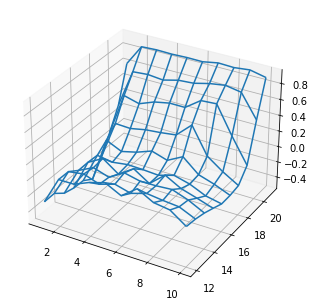

Q-value without Usable Ace


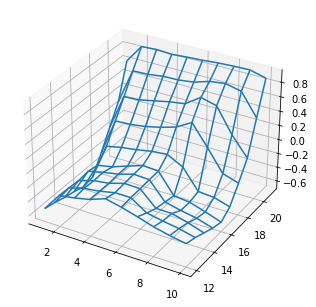

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


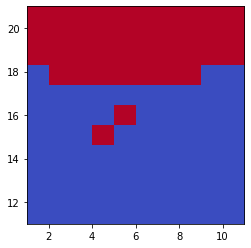

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


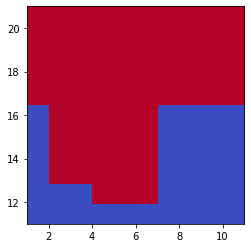

In [9]:
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace=True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace=False)
print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace=True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace=False)

----
## 9. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [10]:
############### 코드 작성 ##############################

money = list()
money.append(10000)
count = 0
total_win = 0
total_loss = 0
total_draw = 0

for i in range(1,1001):
    count += 1
#     m = MonteCarlo()
    epi = mc_es.generate_episode(dealer,agent,deck)
    if epi[-1][-1] == 1:
        money.append(money[-1]+10)
        total_win += 1
    elif epi[-1][-1] == 0:
        money.append(money[-1])
        total_draw += 1
    else:
        money.append(money[-1]-10)
        total_loss += 1
########################################################

### (과제 2) 플레이어의 승률을 계산

In [11]:
############### 코드 작성 ##############################

print(" -- TOTAL WIN RATE : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

########################################################

 -- TOTAL WIN RATE : 33.298%
 -- TOTAL Games WIN : 314 DRAW : 57 LOSS : 629


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

 -- TOTAL REMAIN MONEY :  6850


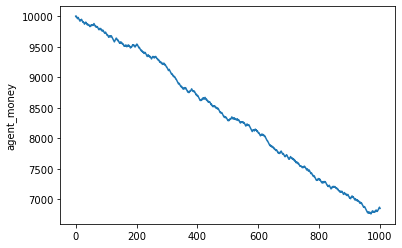

In [12]:
############### 코드 작성 ##############################
print(" -- TOTAL REMAIN MONEY : ",money[-1])
plt.plot(money)
plt.ylabel("agent_money")
plt.show();

########################################################

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



 -- TOTAL WIN RATE : 36.903%
 -- TOTAL Games WIN : 348 DRAW : 57 LOSS : 595
 -- TOTAL REMAIN MONEY :  7530


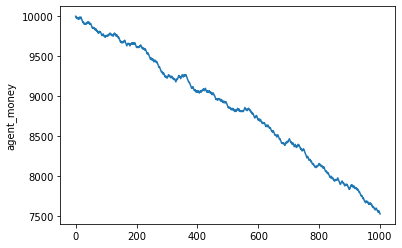

In [15]:
############### 코드 작성 ##############################
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
#         self.remain_ace_10 = 20
#         self.percentage_ace_10 = (self.remain_ace_10 / len(self.card_deck) * 100)/1  #남은 카드 중에 10,ACE의 비율
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        card = self.card_deck.pop()
#         if(card in [10,11]):
#             self.remain_ace_10 -= 1
#         self.percentage_ace_10 = (self.remain_ace_10 / len(self.card_deck) * 100)/1
        return card

    def reset(self):
        if(len(self.card_deck)<15):
            deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
            deck4 = Deck()
            deck4.card_deck = deck * 4
            deck4.shuffle()
            self.card_deck += deck4.card_deck
#             self.remain_ace_10 += 20
#             self.percentage_ace_10 = (self.remain_ace_10 / len(self.card_deck) * 100)/1


class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()
        self.card_count = 0                ##########card_count생성

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.card_count -= 1             ###########agent가 hit할 때마다 card_counting
            self.usable_ace.append(len(self.hands))
        elif new_card == 10:
            self.card_count -= 1          ###########agent가 hit할 때마다 card_counting
        else:
            self.card_count += 1          ###########agent가 hit할 때마다 card_counting
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue
                
        if state[0] >= 17:     ######agent의 sum과 dealer의 show()로로 선택지를 제한한다.
            return False
        elif state[0]>12 and state[0]<=16:
            if state[2] in [2,3,4,5,6]:
                return False
            elif state[2] in [7,8,9,10,11]:
                return True
        elif state[0]==12:
            if state[2] in [4,5,6]:
                return False
            elif state[2] in [2,3,7,8,9,10,11]:
                return True

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)
        
        dealer_show_card = dealer.show()           ###########dealer가 show한 것 card_counting
        if dealer_show_card in [1,10]:
            agent.card_count-=1
        else:
            agent.card_count+=1

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue
#             percentage = deck.percentage_ace_10

            state = (sums, bool(agent.usable_ace),dealer_show_card, agent.card_count)
            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action = agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])
            
#         for i in agent.hands:
#             if i in [10,11]:
#                 agent.card_count -= 1
#             elif i in [2,3,4,5,6]:
#                 agent.card_count += 1
                
        for i in dealer.hands:                ###########한 경기가 끝나면 dealer가 들고 있던 것 card_counting
            if i in [10,11]:
                agent.card_count -= 1
            elif i in [2,3,4,5,6]:
                agent.card_count += 1
                
        if dealer_show_card in [1,10]:       ###########dealer가 show한 것 card_counting 중복 제거
            agent.card_count+=1
        else:
            agent.card_count-=1
                
        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

#                 print("========== Training : Episode ", count, " ===========")
#                 print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
#                 print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
#                 print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
#                 print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
########################################### 학습하기      
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

###########################1000번 실핼
money = list()
money.append(10000)
count = 0
total_win = 0
total_loss = 0
total_draw = 0

for i in range(1,1001):
    count += 1
    epi = mc_es.generate_episode(dealer,agent,deck)
    if epi[-1][-1] == 1:
        money.append(money[-1]+10)
        total_win += 1
    elif epi[-1][-1] == 0:
        money.append(money[-1])
        total_draw += 1
    else:
        money.append(money[-1]-10)
        total_loss += 1
        

print(" -- TOTAL WIN RATE : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)


print(" -- TOTAL REMAIN MONEY : ",money[-1])
plt.plot(money)
plt.ylabel("agent_money")
plt.show();

########################################################

---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html